# Implémentation d'un GAN

Exemple sur la génération de chiffres manuscrits du MNIST  
On utilise ici des [couches convolutives](https://gitlab.com/tncy-algo/deep-learning/-/blob/master/convolution).  
Le même principe s'applique sur des bases de données plus intéressantes, comme des visages (exemple : le [CelebA dataset](https://www.kaggle.com/jessicali9530/celeba-dataset))

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Chargement des données

Rien de compliqué à faire, il suffit de charger les chiffres du MNIST comme dans la séance sur les réseaux de neurones convolutifs ([lien](https://gitlab.com/tncy-algo/deep-learning/-/blob/master/convolution/mnist.py)).  
Le `reshape` permet de transformer les images en niveau de gris (surfaces) en volumes -> on passe d'une shape de `(28, 28)` à `(28, 28, 1)`.

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.reshape(-1, 28, 28, 1).astype(np.float32)
X_train = X_train / 255.

On constitue des batchs de taille **256**.  
On pourra alors simplement itérer sur `train_dataset` pour obtenir toutes les images, par groupe de **256**.

In [3]:
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(60000).batch(256)

## Architecture du modèle

On définit notre **générateur** et notre **discriminateur**.  
De nouvelles couches apparaissent ici :  
 - `BatchNormalization` : les valeurs de toutes les données dans le batch sont [centrées puis réduites](https://fr.wikipedia.org/wiki/Variable_centr%C3%A9e_r%C3%A9duite). Cette opération permet en pratique une meilleure efficacité lors de l'apprentissage
 - `LeakyReLU` : une variante de la ReLU ([image](https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/images/leaky_relu_compare2.png))
 - `Conv2DTranspose` : aussi appelée *couche de déconvolution*, celle-ci applique une convolution dont le résultat est plus grand que l'entrée. On peut également définir un *pas* (stride) de déplacement pour chaque axe. Pour mieux comprendre avec des GIF : [lien](https://beerensahu.wordpress.com/2018/04/10/pytorch-a-fractionally-strided-convolution-or-a-deconvolution/)

In [4]:
def get_generator():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.Reshape((7, 7, 256)),

        tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid')
    ])
    # on vérifie que la sortie de notre réseau de neurones a bien la forme attendue
    assert model.output_shape == (None, 28, 28, 1)

    return model

generator = get_generator()

In [5]:
def get_discriminator():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                        input_shape=[28, 28, 1]),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1)
    ])

    return model

discriminator = get_discriminator()

On définit maintenant les **erreurs** et les **optimisateurs** pour chacun de nos deux réseaux de neurones.  

 - L'erreur du **discriminateur** est définie par la somme des erreurs pour les images réelles et les images générées (fakes). Pour les images réelles, celui-ci doit renvoyer **1**. Pour les images générées, la classification doit être **0**. C'est pourquoi on calcule l'erreur de la sortie par rapport à des 1 et des 0.

 - L'erreur du **générateur** ne s'applique qu'aux cas des images générées (cf présentation). Comme on cherche à augmenter l'erreur du discriminateur, on définit l'erreur du générateur comme étant l'erreur *contraire* du discriminateur. Celle-ci s'obtient en inversant les classes `real` et `fake`, donc en indiquant que l'on souhaite obtenir **1** pour `fake`, et non pas **0** comme pour le discriminateur.

In [6]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return fake_loss

gen_optimizer = tf.keras.optimizers.Adam(2e-4)  # on met un pas d'apprentissage plus petit
disc_optimizer = tf.keras.optimizers.Adam(2e-4) # que celui par défaut (0.001)

## Apprentissage

On ne peut pas utiliser un simple `fit` de Keras comme d'habitude. En effet, on a ici besoin de rétropopager le gradient du discriminateur dans le générateur, de ne pas utiliser le générateur dans tous les cas (on utilisera aussi des images réelles), etc.

On entraîne alors notre modèle **"manuellement"**, comme dans un script de la [première séance](https://gitlab.com/tncy-algo/deep-learning/-/blob/master/introduction/tuto_tf.py) sur Tensorflow.  

On commence pour cela par définir une fonction qui entraîne les réseaux de neurones pour un batch d'images donné :

In [7]:
@tf.function  # <- ce décorateur permet à TensorFlow de "compiler" cette fonction en mémoire
def train_step(images):
    noise = tf.random.normal([256, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # 1: récupération des sorties
        # training=True nous permet de calculer le gradient juste après
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)    # prédictions pour des images réelles
        fake_output = discriminator(generated_images, training=True)  # prédictions pour des "fakes"

        # 2: calcul de l'erreur
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # 3: calcul du gradient
    # comme il s'agit de la dérivée de l'erreur par rapport à chaque variable "entraînable"
    # (poids et biais), on doit... donner l'erreur, et la liste des variables entraînables.
    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # 4: le gradient est donné aux optimisateurs, qui corrigent ensuite les variables
    gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

On génère une *seed*, un vecteur aléatoire de notre espace latent, que l'on utilisera régulièrement pour visualiser l'évolution de la génération au cours de l'entraînement. (pour voir le chiffre évoluer, il faut se déplacer dans l'espace latent)

La fonction **train** a pour rôle d'itérer sur notre dataset d'images pour en récupérer les batchs (un par un) et les passer à notre fonction **`train_step`** définie précédemment. On itère sur toute la base de données plusieurs fois (nombre d'**epochs**).

In [8]:
seed = tf.random.normal([1, 100])

def train(dataset, epochs):
    for epoch in range(epochs):
        
        for image_batch in dataset:
            train_step(image_batch)
        
        # visualisation
        print("Epoch", epoch)
        output = generator(seed)[0]
        plt.imshow(output.numpy().reshape([28, 28]), cmap="bone_r")
        plt.show()

Epoch 0


Epoch 1


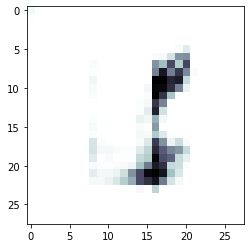

Epoch 2


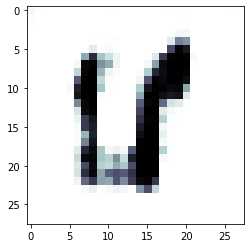

Epoch 3


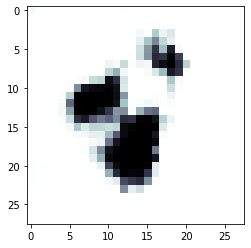

Epoch 4


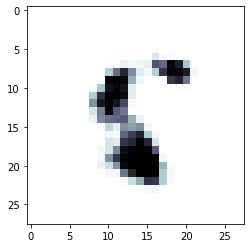

Epoch 5


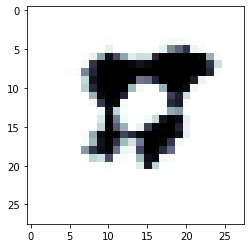

Epoch 6


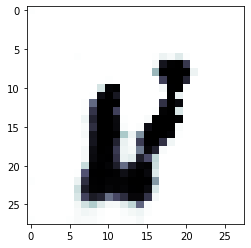

Epoch 7


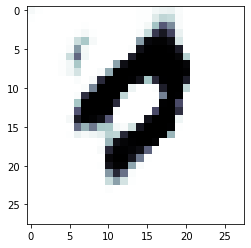

Epoch 8


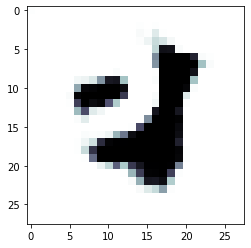

Epoch 9


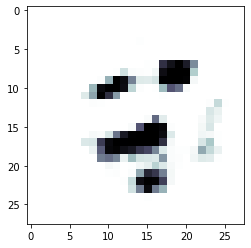

Epoch 10


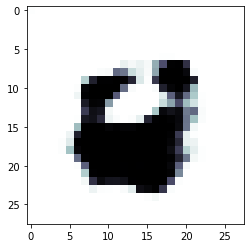

Epoch 11


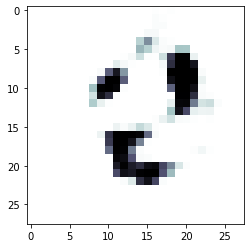

Epoch 12


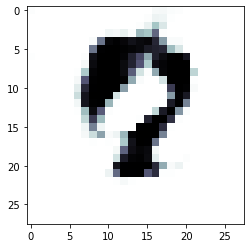

Epoch 13


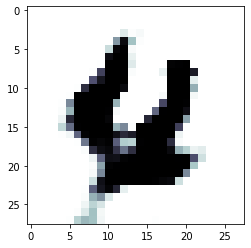

Epoch 14


Epoch 15


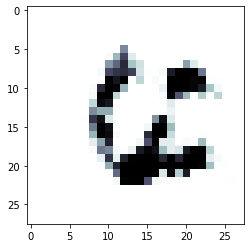

Epoch 16


Epoch 17


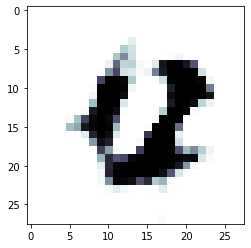

Epoch 18


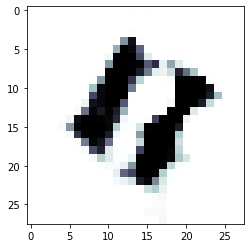

Epoch 19


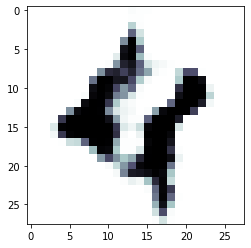

Epoch 20


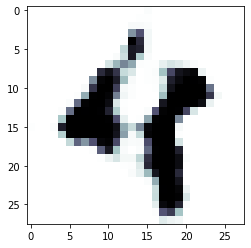

Epoch 21


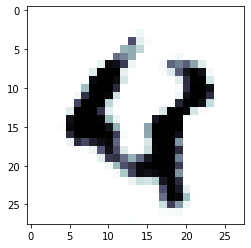

Epoch 22


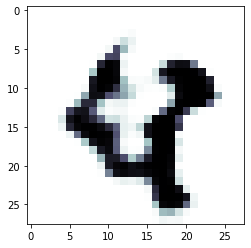

Epoch 23


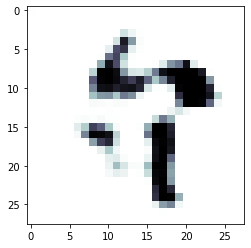

Epoch 24


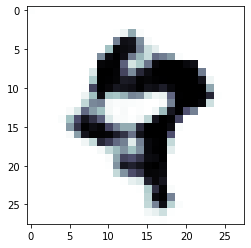

Epoch 25


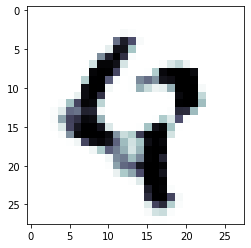

Epoch 26


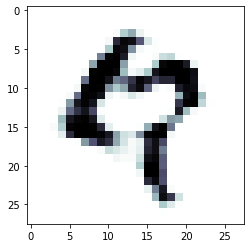

Epoch 27


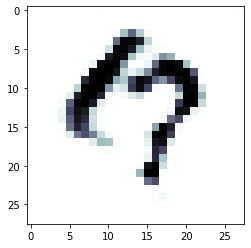

Epoch 28


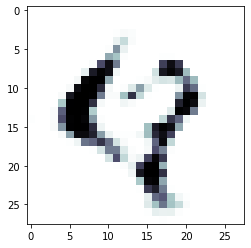

Epoch 29


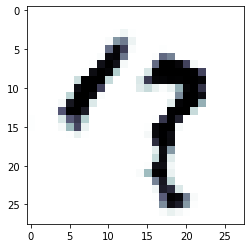

Epoch 30


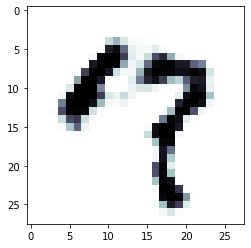

Epoch 31


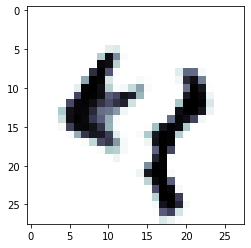

Epoch 32


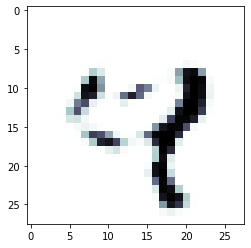

Epoch 33


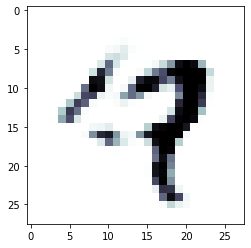

Epoch 34


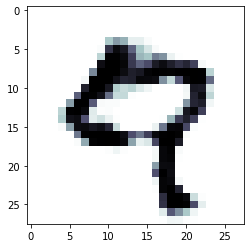

Epoch 35


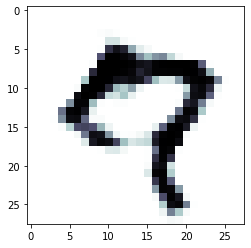

Epoch 36


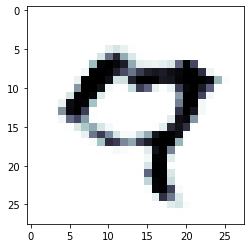

Epoch 37


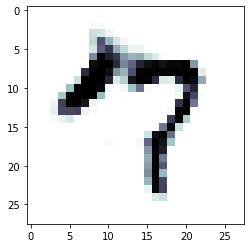

Epoch 38


Epoch 39


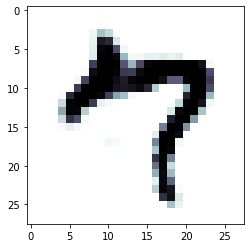

Epoch 40


Epoch 41


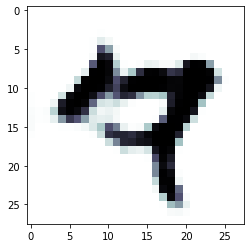

Epoch 42


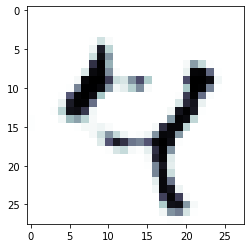

Epoch 43


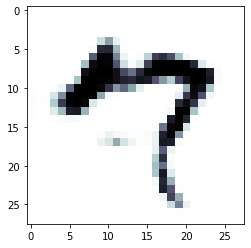

Epoch 44


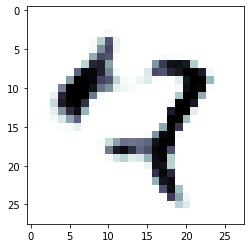

Epoch 45


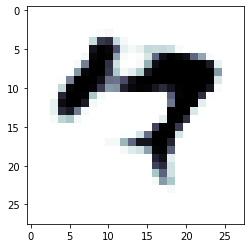

Epoch 46


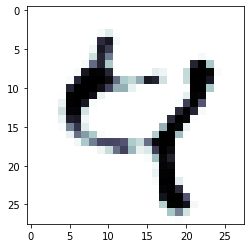

Epoch 47


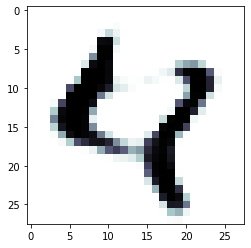

Epoch 48


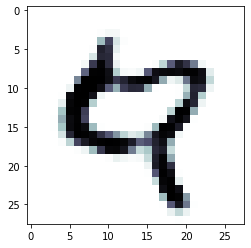

Epoch 49


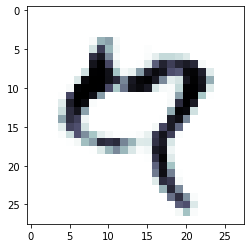

In [9]:
train(train_dataset, epochs=50)